## **Mycotoxin prediction**

This notebook uses a  compact hyperspectral dataset containing spectral reflectance data of corn samples across multiple wavelength bands. Each row represents a corn sample, and the features are the reflectance values at different wavelengths. The target is to predict the DON concentration which is a continous variable.

This notebook experiments with 3 different approaches and compares their performance on this task. But before that lets take a better look at the dataset.

# Importing necessary libraries and reading the dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

In [ ]:
sns.set(style="whitegrid")

In [ ]:
# Load the dataset
df = pd.read_csv('/content/MLE-Assignment.csv')

In [ ]:
df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


# Checking for null values

In [ ]:
# Check for missing values
df.isnull().sum().max()

,0
hsi_id,0
0,0
1,0
2,0
3,0
...,...
444,0
445,0
446,0
447,0


# EDA & Data Visualizations

In [ ]:
# Summary statistics
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


In [ ]:
# Separate features and target
X = df.drop(['hsi_id', 'vomitoxin_ppb'], axis=1)
y = df['vomitoxin_ppb']

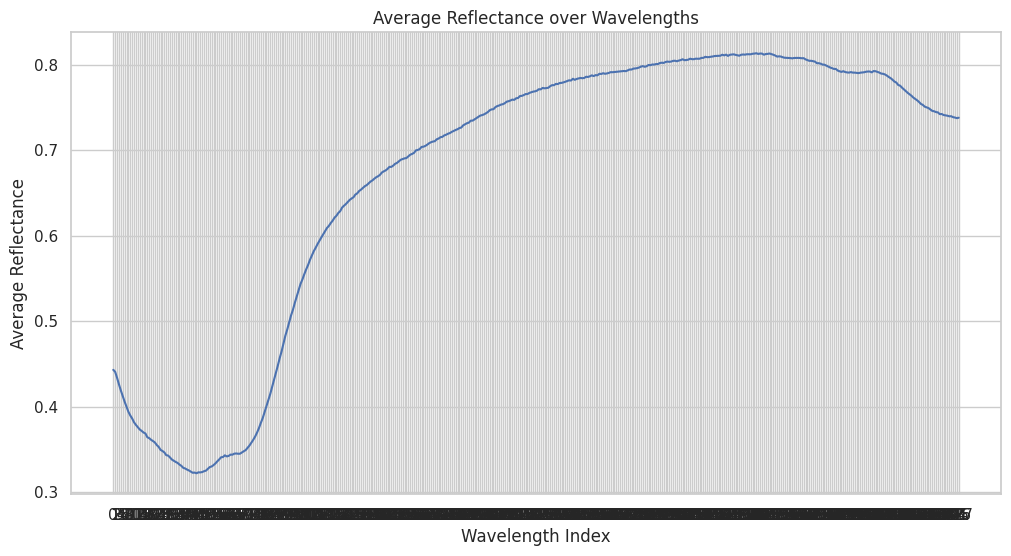

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(X.mean())
plt.title('Average Reflectance over Wavelengths')
plt.xlabel('Wavelength Index')
plt.ylabel('Average Reflectance')
plt.show()

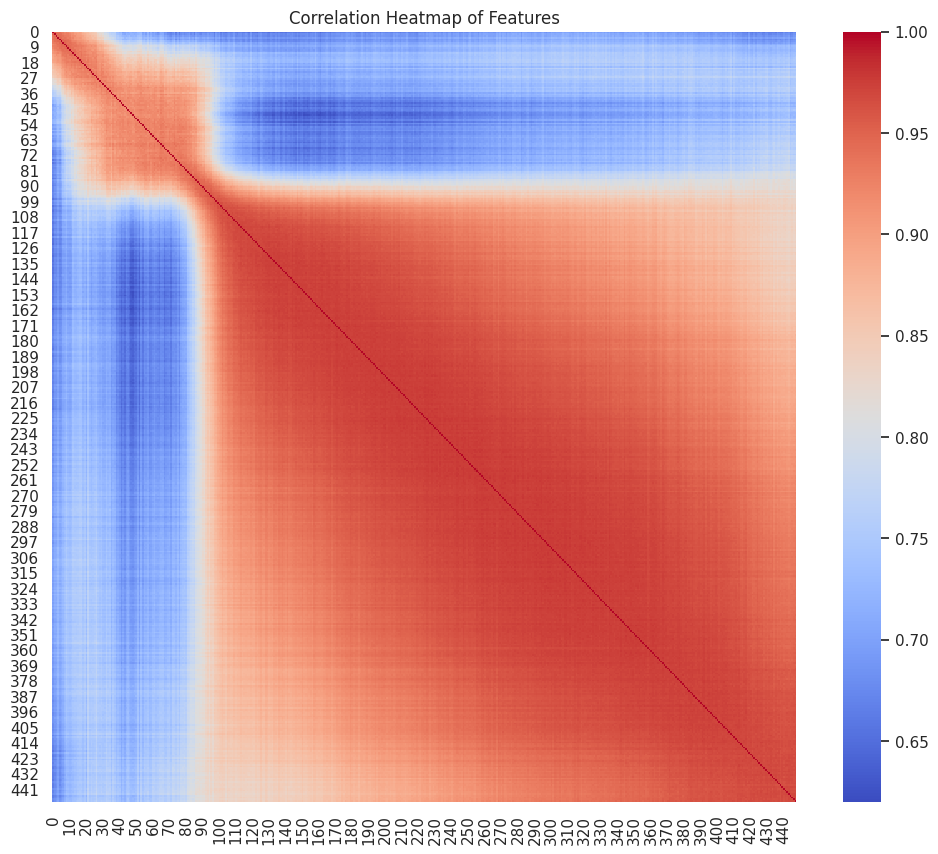

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

From the above plots, its clear that their is very high corelation between the features as expected. For better use of this as a dataset to any ML model, its crucial that we use lesser number of uncorelated features.

To be able to do so we use PCA

# PCA

In [ ]:
# Normalize the spectral data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [ ]:
print(f"Number of components after PCA: {X_pca.shape[1]}")

Number of components after PCA: 3


# Train test split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Modelling

Now that we have our dataset ready for training the ML models, lets take a look at the different approaches that we are using for this experiment

1. Multilayer perceptron/ANN (Baseline Model)
2. Ensemble Model
3. Attention network

Lets experiments with these approaches and compare the results






# MLP Baseline

In [ ]:
# Define the model
model = MLPRegressor(random_state=42)

# Hyperparameter optimization
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

In [ ]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_baseline = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
y_pred_baseline = best_model_baseline.predict(X_test)

In [ ]:
# Calculate metrics
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Mean Absolute Error: {mae_baseline}")
print(f"Root Mean Squared Error: {rmse_baseline}")
print(f"R² Score: {r2_baseline}")

Mean Absolute Error: 4656.482557520661
Root Mean Squared Error: 14028.30671579144
R² Score: 0.2959925670333047


# Ensemble Approach

In [ ]:
# Define individual models
mlp = MLPRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Create ensemble
models = [mlp, rf, gb]

# Train models
for model in models:
    model.fit(X_train, y_train)

# Make predictions
ensemble_predictions = np.mean([model.predict(X_test) for model in models], axis=0)

# Evaluate ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
ensemble_r2 = r2_score(y_test, ensemble_predictions)

print(f"Ensemble MAE: {ensemble_mae}")
print(f"Ensemble RMSE: {ensemble_rmse}")
print(f"Ensemble R² Score: {ensemble_r2}")

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble MAE: 2250.524357316887
Ensemble RMSE: 6413.186745705893
Ensemble R² Score: 0.8528655020727446


# Attention Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define attention layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute attention weights
        et = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        at = tf.keras.backend.softmax(et, axis=1)  # Apply softmax along the sequence axis

        # Apply attention
        output = tf.keras.backend.sum(x * at, axis=1)
        return output

# Define model architecture
def create_attention_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))

    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Reshape((1, 64))(x)
    x = AttentionLayer()(x)
    x = layers.Reshape((-1,))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
attention_model = create_attention_model(X_train.shape[1])
attention_model.compile(optimizer='adam', loss='mse')

# Train the model
history = attention_model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=32, verbose=0)

# Make predictions
attention_predictions = attention_model.predict(X_test).flatten()  # Flatten predictions

# Evaluate attention model
attention_mae = mean_absolute_error(y_test, attention_predictions)
attention_rmse = np.sqrt(mean_squared_error(y_test, attention_predictions))
attention_r2 = r2_score(y_test, attention_predictions)

print(f"Attention Model MAE: {attention_mae}")
print(f"Attention Model RMSE: {attention_rmse}")
print(f"Attention Model R² Score: {attention_r2}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Attention Model MAE: 2003.642831363678
Attention Model RMSE: 4943.426986340858
Attention Model R² Score: 0.9125775472286066


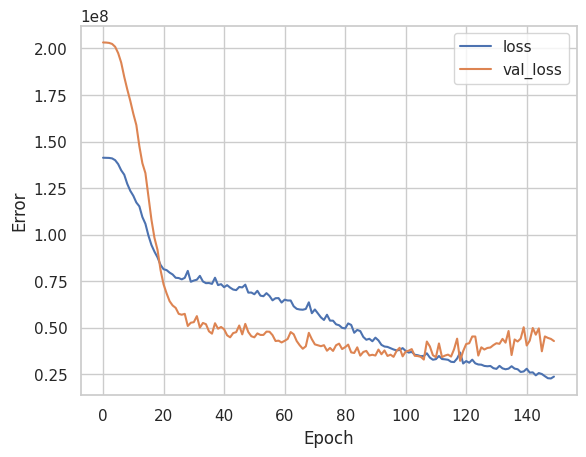

In [ ]:
# Plotting the loss and validation loss of the network
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Comparison

In [ ]:
models = ['Baseline', 'Ensemble', 'Attention Model']
mae_scores = [mae_baseline, ensemble_mae, attention_mae]
rmse_scores = [rmse_baseline, ensemble_rmse, attention_rmse]
r2_scores = [r2_baseline, ensemble_r2, attention_r2]

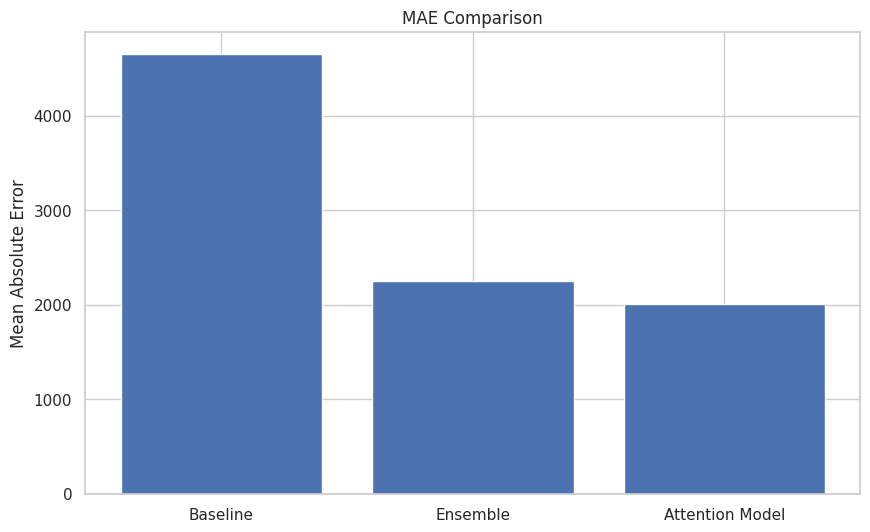

In [ ]:
#Plotting MAEs
plt.figure(figsize=(10, 6))
plt.bar(models, mae_scores)
plt.title('MAE Comparison')
plt.ylabel('Mean Absolute Error')
plt.show()

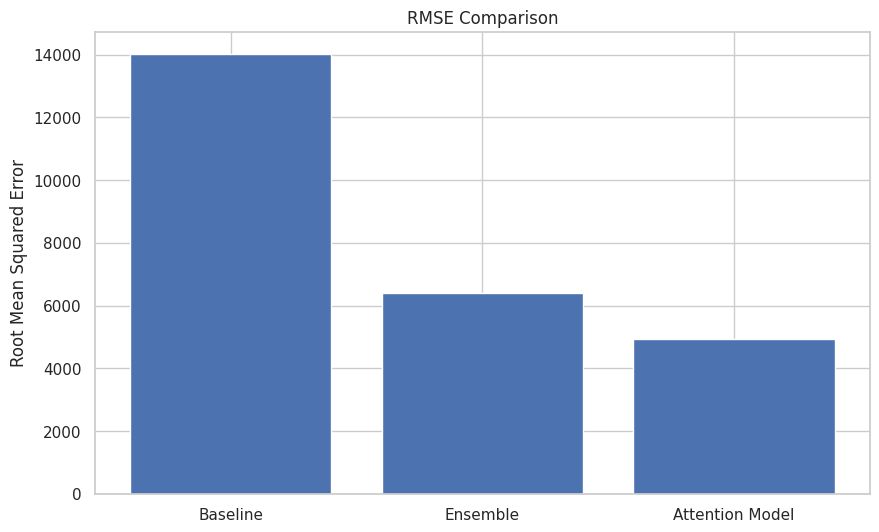

In [ ]:
#Plotting RMSEs
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores)
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')
plt.show()

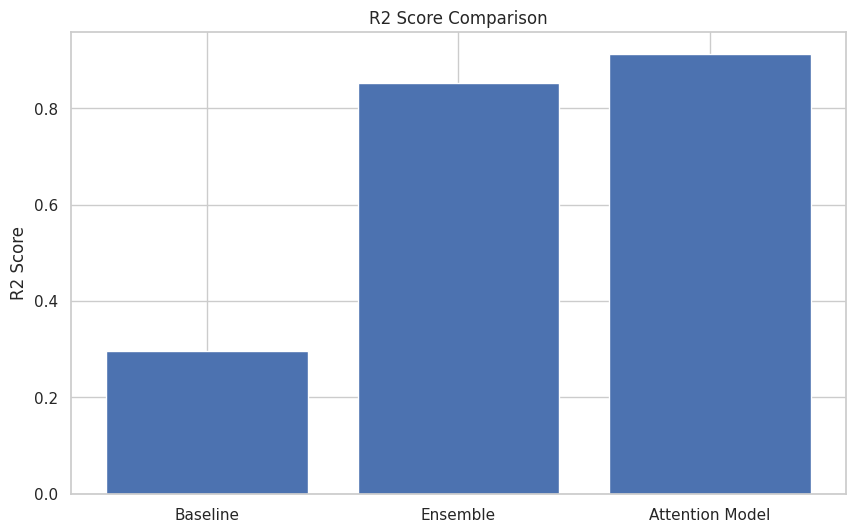

In [ ]:
#Plotting R2 Score
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores)
plt.title('R2 Score Comparison')
plt.ylabel('R2 Score')
plt.show()

# Visualizing the model predictions with actual values

In [ ]:
best_model_index = np.argmax(r2_scores)
best_model_name = models[best_model_index]
best_predictions = [y_pred_baseline, ensemble_predictions, attention_predictions][best_model_index]

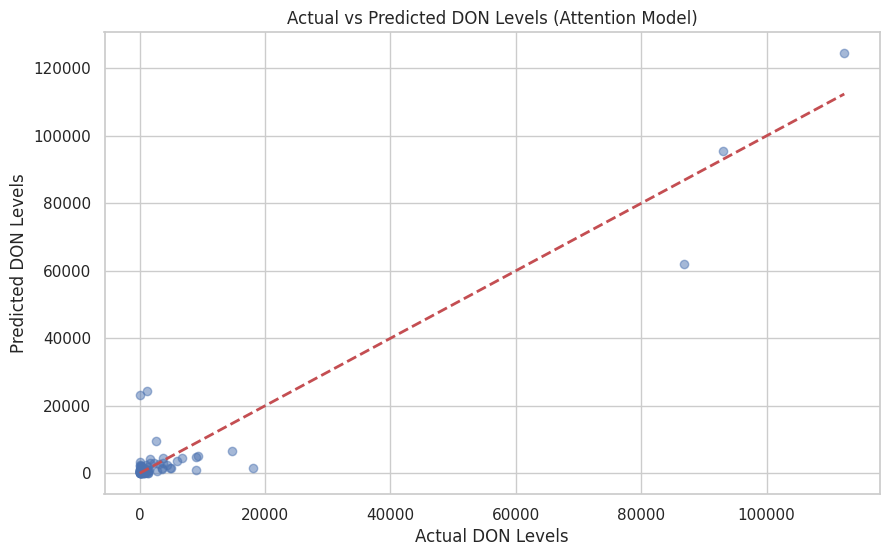

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DON Levels')
plt.ylabel('Predicted DON Levels')
plt.title(f'Actual vs Predicted DON Levels ({best_model_name})')
plt.show()

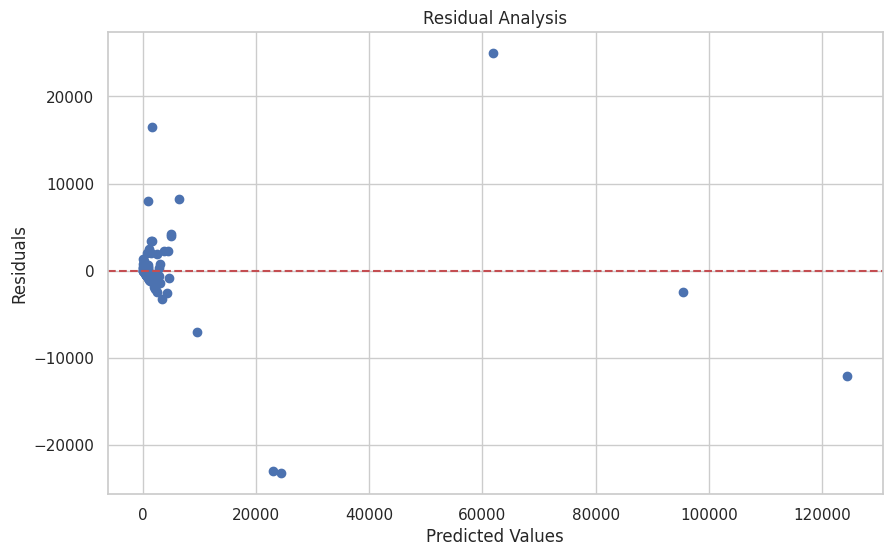

In [ ]:
residuals = y_test - best_predictions
plt.figure(figsize=(10, 6))
plt.scatter(best_predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# SHAP plots

In [ ]:
# Generate PCA component names
pca_feature_names = [f'PC{i+1}' for i in range(X_train.shape[1])]

Model input shape: (None, 3)
Model output shape: (None, 1)


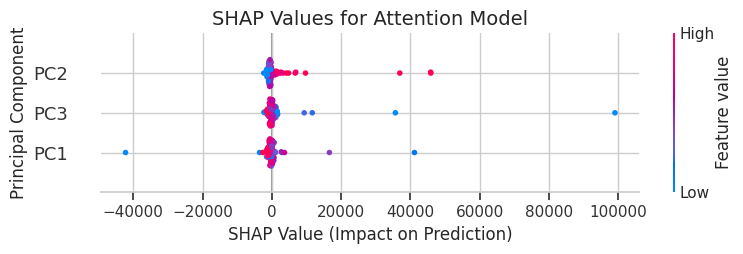

In [ ]:
# Modified SHAP explanation code with dimension correction
def create_shap_plot():
    # Verify model input/output dimensions
    print(f"Model input shape: {attention_model.input_shape}")
    print(f"Model output shape: {attention_model.output_shape}")

    # Create SHAP explainer with proper input handling
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(
        attention_model,
        background.reshape((-1, X_train.shape[1]))
    )

    # Generate SHAP values with dimension correction
    test_sample = X_test[:100]
    shap_values = explainer.shap_values(test_sample)

    # Remove extra dimension from SHAP values
    shap_values = np.squeeze(shap_values)  # Changes shape from (100, 3, 1) to (100, 3)

    # Verify corrected shapes match
    assert shap_values.shape == test_sample.shape, \
        f"Shape mismatch after correction: SHAP {shap_values.shape} vs Data {test_sample.shape}"

    # Create summary plot with PCA component labels
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        test_sample,
        feature_names=[f'PC{i+1}' for i in range(X_train.shape[1])],
        plot_type='dot',
        show=False
    )
    plt.title('SHAP Values for Attention Model', fontsize=14)
    plt.xlabel('SHAP Value (Impact on Prediction)', fontsize=12)
    plt.ylabel('Principal Component', fontsize=12)
    plt.tight_layout()
    plt.show()

create_shap_plot()


# PCA feature contributors

In [ ]:
# Analyze PCA loadings to connect components with spectral features
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pca_feature_names,
    index= df.columns[1:-1]
)

# Show top wavelengths contributing to most important PCA components
top_components = [f'PC{i+1}' for i in range(3)]
loading_analysis = loadings[top_components].apply(
    lambda x: x.abs().nlargest(10).index.tolist()
)
print("Top wavelength contributors for key PCA components:")
loading_analysis


Top wavelength contributors for key PCA components:


,PC1,PC2,PC3
0,278,52,104
1,295,47,108
2,271,41,110
3,309,48,107
4,286,50,111
5,269,43,106
6,294,49,112
7,314,46,114
8,291,54,120
9,277,42,109
